In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [4]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

### 1. Размер кредитного лимита (LIMIT_BAL). 
В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 

a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Значимы ли полученные результаты с практической точки зрения ?

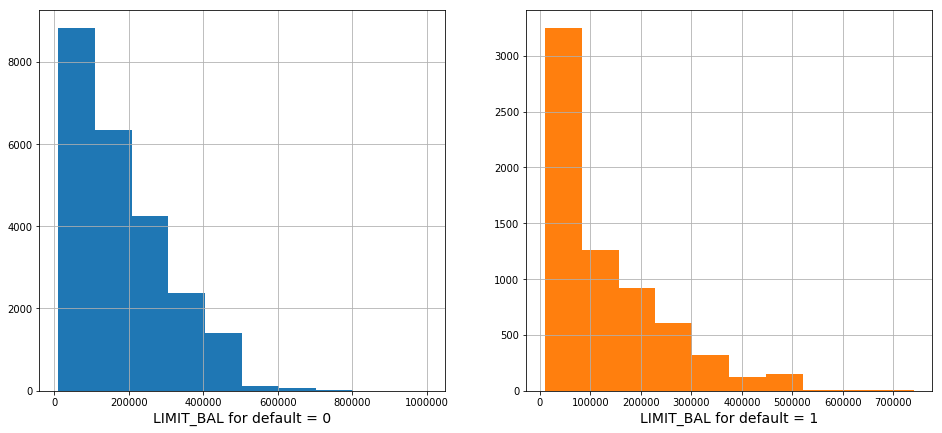

In [5]:
plt.figure(figsize=(16,7))
plt.subplot(121)
data[data.default == 0]['LIMIT_BAL'].hist(color = '#1f77b4')
plt.xlabel('LIMIT_BAL for default = 0', fontsize=14)

plt.subplot(122)
data[data.default == 1]['LIMIT_BAL'].hist(color = '#ff7f0e')
plt.xlabel('LIMIT_BAL for default = 1', fontsize=14)
plt.show()

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [7]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
limit_bal_0 = data[data.default == 0].LIMIT_BAL.values
limit_bal_1 = data[data.default == 1].LIMIT_BAL.values

In [9]:
limit_median_0 = list(map(np.median, get_bootstrap_samples(limit_bal_0, 1000)))
limit_median_1 = list(map(np.median, get_bootstrap_samples(limit_bal_1, 1000)))

print("95% confidence interval for the default=0 LIMIT_BAL median:",  stat_intervals(limit_median_0, 0.05))
print("95% confidence interval for the default=1 LIMIT_BAL median:",  stat_intervals(limit_median_1, 0.05))

95% confidence interval for the default=0 LIMIT_BAL median: [150000. 150000.]
95% confidence interval for the default=1 LIMIT_BAL median: [80000. 90000.]


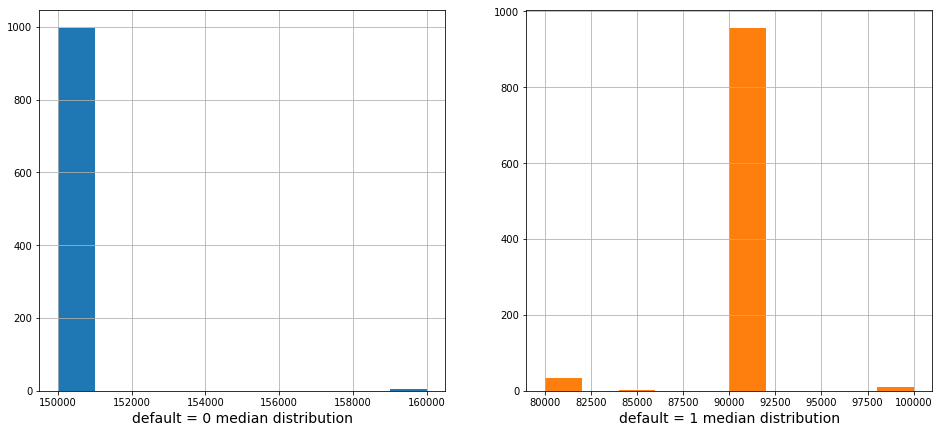

In [10]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.hist(limit_median_0, color = '#1f77b4')
plt.grid()
plt.xlabel('default = 0 median distribution', fontsize=14)

plt.subplot(122)
plt.hist(limit_median_1, color = '#ff7f0e')
plt.grid()
plt.xlabel('default = 1 median distribution', fontsize=14)
plt.show()

Точечная оценка разности медиан:

In [11]:
print("difference between medians:", np.median(limit_bal_0) - np.median(limit_bal_1))

difference between medians: 60000.0


Интервальная оценка разности медиан:

In [12]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(limit_median_1, limit_median_0)))
print( "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [60000. 70000.]


### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [13]:
stats.mannwhitneyu(limit_bal_0, limit_bal_1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

In [14]:
def fold_change(C, T):
    if T > C:
        return T / C
    else:
        return -C / T

In [15]:
def valuable_fc_count(control, treatment, threshold):
    fc_count = 0
    for c, t in zip(control, treatment):
        if np.abs(fold_change(c, t)) > threshold:
            fc_count += 1
    return fc_count

Количество значимых отличий c abs(fold change) > 1.5 при сравнении бутстрапированных наборов выборок LIMIT_BALL для default = 0 и LIMIT_BALL для default = 1 объема 1000

In [16]:
valuable_fc_count(limit_median_0, limit_median_1, 1.5)

990

Вывод: получили 989 практически значимых результата из 1000

### 2. Пол (SEX): 
    
Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

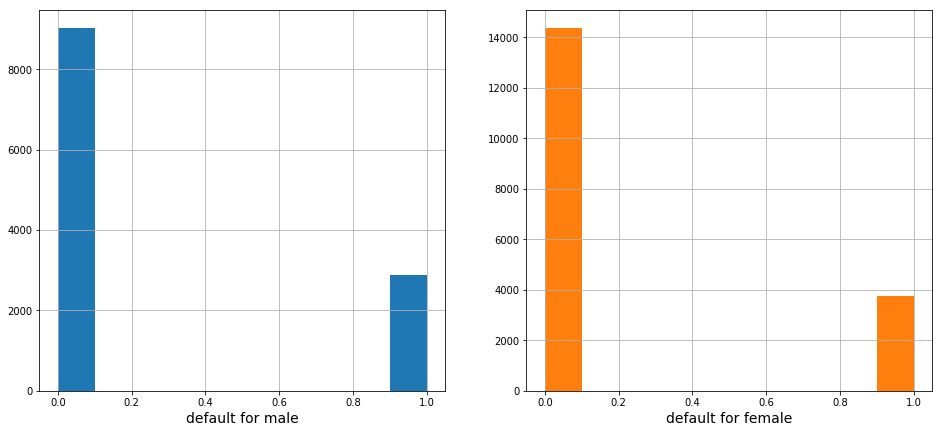

In [17]:
plt.figure(figsize=(16,7))
plt.subplot(121)
data[data.SEX == 1]['default'].hist(color = '#1f77b4')
plt.xlabel('default for male', fontsize=14)

plt.subplot(122)
data[data.SEX == 2]['default'].hist(color = '#ff7f0e')
plt.xlabel('default for female', fontsize=14)
plt.show()

In [18]:
from statsmodels.stats.proportion import proportion_confint

### Интервальные оценки долей

In [19]:
default_male = data[data.SEX == 1]['default']
default_female = data[data.SEX == 2]['default']

Поправим немного выборки, будем считать что 1 - кредит вернули (успех), 0 - кредит не вернули (неудача). Это нужно для интерпретации доверительных интервалов.

In [20]:
default_male = default_male.apply(lambda x: 1 if x == 0 else 0)

In [21]:
default_female = default_female.apply(lambda x: 1 if x == 0 else 0)

Построим доверительные интервалы используя метод Уилсона


$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [22]:
conf_interval_male = proportion_confint(np.sum(default_male), 
                                            len(default_male),
                                            method = 'wilson')
conf_interval_female = proportion_confint(np.sum(default_female), 
                                            len(default_female),
                                            method = 'wilson')

In [23]:
print('interval for banner a [%f, %f]' % conf_interval_male)
print('interval for banner b [%f, %f]' % conf_interval_female)

interval for banner a [0.750550, 0.765939]
interval for banner b [0.786267, 0.798083]


Вывод: Доверительные интервалы не пересекаются, можно предположить, что женщины чаще погашают задолженности по кредиту.

### Доверительный интервал для разности долей (независимые выборки)

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [24]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [25]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(default_female, default_male))

confidence interval: [0.024207, 0.043612]


Вывод: Разность двух долей не включает 0, значит гендерный состав вернувших и не вернувших кредит отличается.

### Z-критерий для разности долей (независимые выборки)

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [26]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [27]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [28]:
print(f"p-value: {proportions_diff_z_test(proportions_diff_z_stat_ind(default_female, default_male))}")

p-value: 4.472866521609831e-12


Используя Z-критерий, гипотеза о гендерном равенстве уверенно отвергается. При проверке того, что женщины лучше погашают кредит уровень значимости будет еще меньше: 

In [29]:
print(f"p-value: {proportions_diff_z_test(proportions_diff_z_stat_ind(default_female, default_male), alternative='greater')}")

p-value: 2.2364332608049153e-12


### 3. Образование (EDUCATION): 

Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? наоборт, не отдаст долг?

In [30]:
def draw_plots(x, y, fsize, datas, labels, colors):
    fig, axes = plt.subplots(x, y, figsize=fsize)
    
    ds, ls, cs = 0, 0, 0
    
    for i in range(x):
        for j in range(y):
            try:
                axes[i][j].hist(datas[ds], color = colors[cs])
                axes[i][j].set_xlim(0, 1)
                axes[i][j].grid()
                axes[i][j].set_xlabel(labels[ls])
                ds += 1
                ls += 1
                cs += 1
            except:
                break
    plt.show()

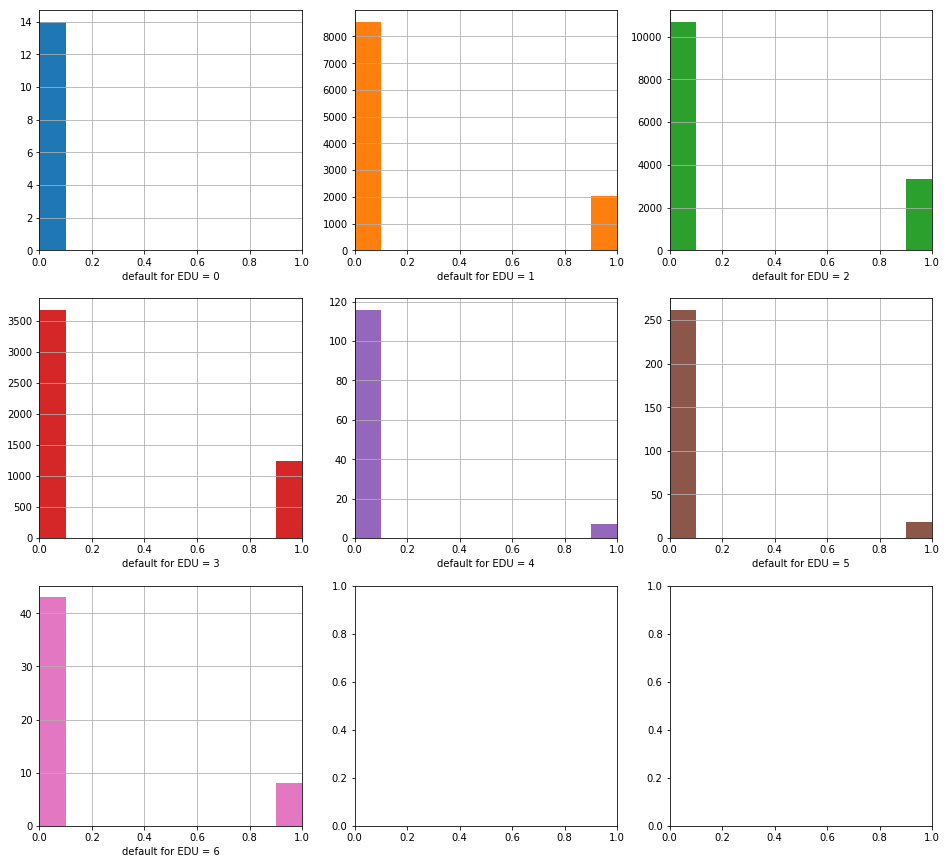

In [31]:
datas = [data[data.EDUCATION == 0]['default'], 
         data[data.EDUCATION == 1]['default'], 
         data[data.EDUCATION == 2]['default'],
         data[data.EDUCATION == 3]['default'],
         data[data.EDUCATION == 4]['default'],
         data[data.EDUCATION == 5]['default'],
         data[data.EDUCATION == 6]['default']]
labels = ['default for EDU = 0', 
          'default for EDU = 1', 
          'default for EDU = 2', 
          'default for EDU = 3', 
          'default for EDU = 4', 
          'default for EDU = 5', 
          'default for EDU = 6']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
draw_plots(3, 3, (16, 15), datas, labels, colors)

In [32]:
def_edu = pd.crosstab(data.default, [data.EDUCATION])
g, p, dof, expctd = stats.chi2_contingency(def_edu)

Таблица сопряженности:

In [33]:
def_edu

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


Таблица с ожидаемыми значениями:

In [34]:
pd.DataFrame(expctd)

,0,1,2,3,4,5,6
0,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188
1,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812


Таблица разностей наблюдаемых и ожидаемых значений:

In [35]:
diff_def_edu = def_edu - expctd
diff_def_edu

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
1,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


Полченный p уровень значимости позволяет отвергнуть гипотезу о независимости возврата кредита от образования:

In [36]:
print(f"p-value: {p}")

p-value: 1.2332626245415605e-32


Произведем масштабирование ячеек на интервал [-1, 1]:

In [37]:
min_x = np.min(np.min(diff_def_edu))
max_x = np.max(np.max(diff_def_edu))
diff_def_edu.apply(lambda x: 2 * (x - min_x)/(max_x - min_x) - 1)

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,0.01014,1.0,-0.741855,-0.489059,0.066167,0.143863,0.010744
1,-0.01014,-1.0,0.741855,0.489059,-0.066167,-0.143863,-0.010744


In [38]:
def proportions_diff_z_stat_ind2(sample1, sample2):
    n1 = sum(sample1)
    n2 = sum(sample2)
    
    p1 = sample1[0] / n1
    p2 = sample2[0] / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

Посчитаем Z-статистику по всем парам значений колонки EDUCATION:

In [39]:
tests = []

for i, lhs_column in enumerate(def_edu):
    for j, rhs_column in enumerate(def_edu):
        if i >= j:
            continue
        
        test = proportions_diff_z_stat_ind2(def_edu[lhs_column], def_edu[rhs_column])
        tests.append([lhs_column, rhs_column, test, proportions_diff_z_test(test)])

In [40]:
edu_tests = pd.DataFrame.from_records(tests)
edu_tests.columns = ['EDU_A', 'EDU_B', 'statistic', 'p']

In [41]:
edu_tests.head()

,EDU_A,EDU_B,statistic,p
0,0,1,1.825690,0.067897
1,0,2,2.087021,0.036886
2,0,3,2.168292,0.030136
3,0,4,0.916324,0.359497
4,0,5,0.979130,0.327516


Проверим сколько значимых отличий получили:

In [42]:
(edu_tests.p < 0.05).value_counts()

True     13
False     8
Name: p, dtype: int64

In [43]:
edu_tests[edu_tests.p < 0.05]

,EDU_A,EDU_B,statistic,p
1,0,2,2.087021,3.688621e-02
2,0,3,2.168292,3.013646e-02
6,1,2,8.465756,0.000000e+00
7,1,3,8.409142,0.000000e+00
8,1,4,-3.800768,1.442485e-04
9,1,5,-5.401901,6.593846e-08
11,2,3,2.007181,4.473034e-02
12,2,4,-4.693774,2.682109e-06
13,2,5,-6.773199,1.259659e-11
15,3,4,-4.945769,7.584381e-07


Сделаем поправку на множественную проверку гипотез.

In [44]:
import statsmodels.stats.multitest as smm

Сначала используем метод Холма:

In [45]:
reject, p_corrected, a1, a2 = smm.multipletests(edu_tests.p, 
                                            alpha = 0.05, 
                                            method = 'holm')

In [46]:
edu_tests['p_corrected'] = p_corrected
edu_tests['reject'] = reject

In [47]:
edu_tests.head()

,EDU_A,EDU_B,statistic,p,p_corrected,reject
0,0,1,1.825690,0.067897,0.543176,False
1,0,2,2.087021,0.036886,0.368862,False
2,0,3,2.168292,0.030136,0.361637,False
3,0,4,0.916324,0.359497,1.000000,False
4,0,5,0.979130,0.327516,1.000000,False


In [48]:
edu_tests.reject.value_counts()

False    13
True      8
Name: reject, dtype: int64

In [49]:
edu_tests[edu_tests.p_corrected < 0.05]

,EDU_A,EDU_B,statistic,p,p_corrected,reject
6,1,2,8.465756,0.000000e+00,0.000000e+00,True
7,1,3,8.409142,0.000000e+00,0.000000e+00,True
8,1,4,-3.800768,1.442485e-04,2.019479e-03,True
9,1,5,-5.401901,6.593846e-08,1.120954e-06,True
12,2,4,-4.693774,2.682109e-06,4.023164e-05,True
13,2,5,-6.773199,1.259659e-11,2.267386e-10,True
15,3,4,-4.945769,7.584381e-07,1.213501e-05,True
16,3,5,-7.122639,1.058709e-12,2.011546e-11,True


Попробуем использовать метод Бенджамини-Хохберга:

In [50]:
reject, p_corrected, a1, a2 = smm.multipletests(edu_tests.p, 
                                            alpha = 0.05, 
                                            method = 'fdr_bh')

In [51]:
edu_tests['p_corrected'] = p_corrected
edu_tests['reject'] = reject

In [52]:
edu_tests.head()

,EDU_A,EDU_B,statistic,p,p_corrected,reject
0,0,1,1.825690,0.067897,0.101846,False
1,0,2,2.087021,0.036886,0.064551,False
2,0,3,2.168292,0.030136,0.062037,False
3,0,4,0.916324,0.359497,0.397339,False
4,0,5,0.979130,0.327516,0.382102,False


In [53]:
edu_tests.reject.value_counts()

False    13
True      8
Name: reject, dtype: int64

In [54]:
edu_tests[edu_tests.p_corrected < 0.05]

,EDU_A,EDU_B,statistic,p,p_corrected,reject
6,1,2,8.465756,0.000000e+00,0.000000e+00,True
7,1,3,8.409142,0.000000e+00,0.000000e+00,True
8,1,4,-3.800768,1.442485e-04,3.786523e-04,True
9,1,5,-5.401901,6.593846e-08,2.769415e-07,True
12,2,4,-4.693774,2.682109e-06,8.046328e-06,True
13,2,5,-6.773199,1.259659e-11,6.613210e-11,True
15,3,4,-4.945769,7.584381e-07,2.654533e-06,True
16,3,5,-7.122639,1.058709e-12,7.410961e-12,True


Видим, что значимые отличия групп не изменились.

Вывод: Наличие образование 4 и 5 является наилучшим индикатором того, что человек отдаст долг. Напротив наличие образования 2 и 3 является индикатором того, что человек скорее всего долг не отдаст.

### 4. Семейное положение (MARRIAGE): 
Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [55]:
unique, counts = np.unique(data.MARRIAGE, return_counts=True)

In [56]:
dict(zip(unique, counts))

{0: 54, 1: 13659, 2: 15964, 3: 323}

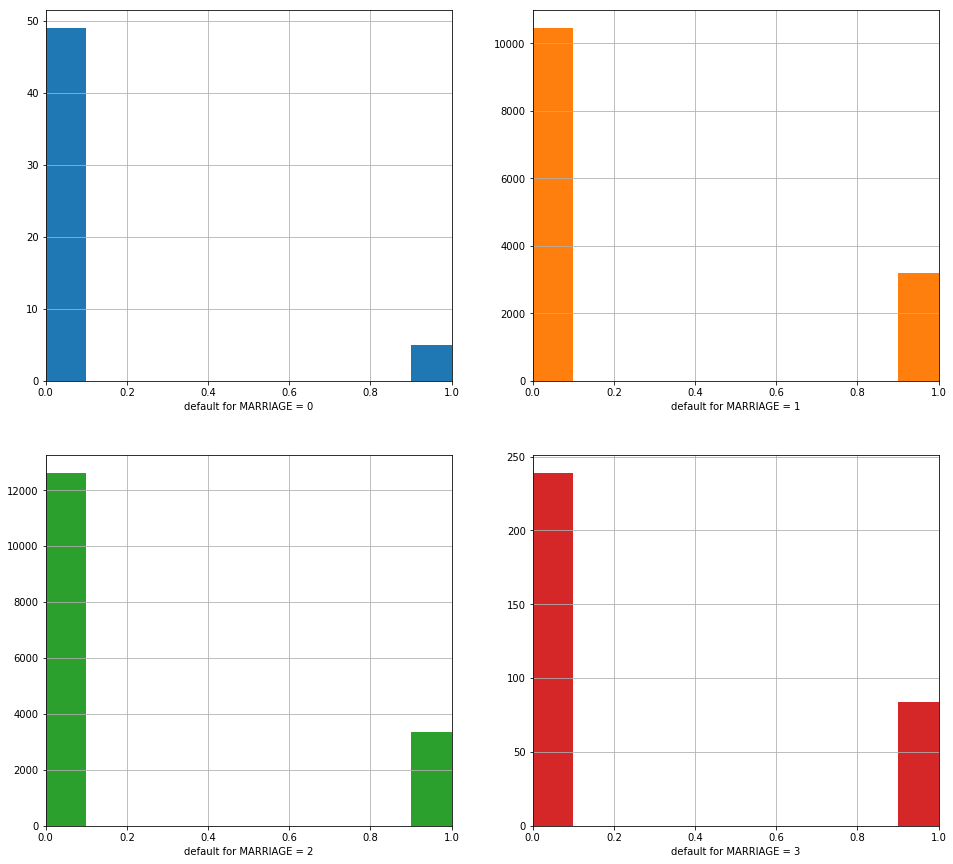

In [57]:
datas = [data[data.MARRIAGE == 0]['default'], 
         data[data.MARRIAGE == 1]['default'], 
         data[data.MARRIAGE == 2]['default'],
         data[data.MARRIAGE == 3]['default']]
labels = ['default for MARRIAGE = 0', 
          'default for MARRIAGE = 1', 
          'default for MARRIAGE = 2', 
          'default for MARRIAGE = 3']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
draw_plots(2, 2, (16, 15), datas, labels, colors)

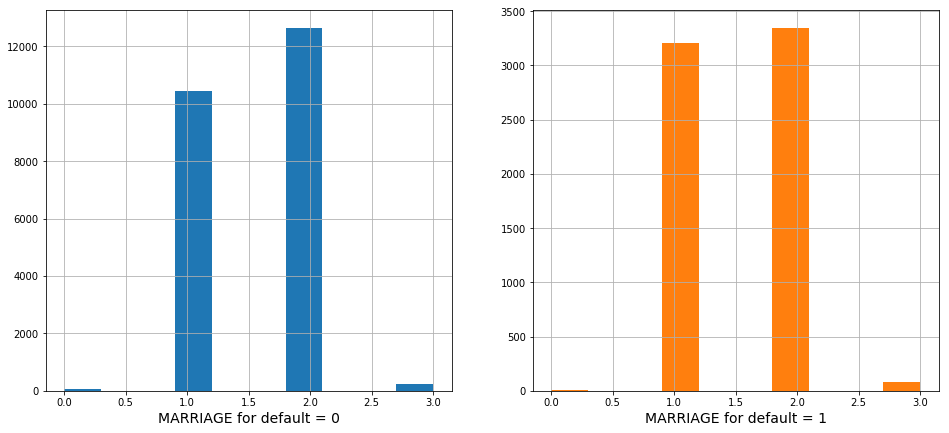

In [58]:
plt.figure(figsize=(16,7))
plt.subplot(121)
data[data.default == 0]['MARRIAGE'].hist(color = '#1f77b4')
plt.xlabel('MARRIAGE for default = 0', fontsize=14)

plt.subplot(122)
data[data.default == 1]['MARRIAGE'].hist(color = '#ff7f0e')
plt.xlabel('MARRIAGE for default = 1', fontsize=14)
plt.show()

Так как оба признака (default и MARRIAGE) являются категориальными, целесообразно в качестве меры, по которой можно измерить возможную связь этих переменных, взять критерий V Крамера.

In [59]:
def_marr = pd.crosstab(data.default, [data.MARRIAGE])
g, p, dof, expctd = stats.chi2_contingency(def_marr)

Таблица сопряженности:

In [60]:
def_marr

MARRIAGE,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


Показатель $\phi_c$ равен:

In [61]:
phi_c = np.sqrt(g / (np.sum(np.sum(def_marr)) * (min(def_marr.shape) - 1)))
phi_c

0.034478203662766466

### 5. Возраст (AGE): 
    
Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы:

a) о равенстве медианных значений возрастов людей

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Значимы ли полученные результаты с практической точки зрения ?

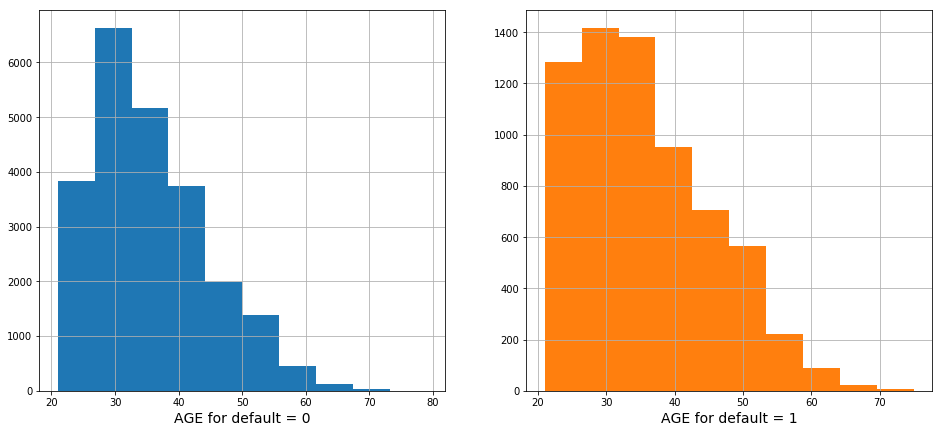

In [62]:
plt.figure(figsize=(16,7))
plt.subplot(121)
data[data.default == 0]['AGE'].hist(color = '#1f77b4')
plt.xlabel('AGE for default = 0', fontsize=14)

plt.subplot(122)
data[data.default == 1]['AGE'].hist(color = '#ff7f0e')
plt.xlabel('AGE for default = 1', fontsize=14)
plt.show()

In [63]:
age_0 = data[data.default == 0].AGE.values
age_1 = data[data.default == 1].AGE.values

In [64]:
age_median_0 = list(map(np.median, get_bootstrap_samples(age_0, 100)))
age_median_1 = list(map(np.median, get_bootstrap_samples(age_1, 100)))

print("95% confidence interval for the default=0 AGE median:",  stat_intervals(age_median_0, 0.05))
print("95% confidence interval for the default=1 AGE median:",  stat_intervals(age_median_1, 0.05))

95% confidence interval for the default=0 AGE median: [34. 34.]
95% confidence interval for the default=1 AGE median: [34. 35.]


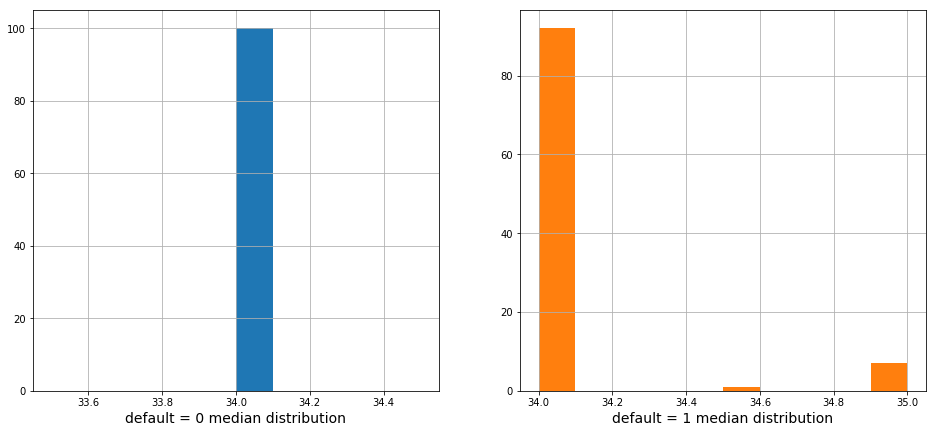

In [65]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.hist(age_median_0, color = '#1f77b4')
plt.grid()
plt.xlabel('default = 0 median distribution', fontsize=14)

plt.subplot(122)
plt.hist(age_median_1, color = '#ff7f0e')
plt.grid()
plt.xlabel('default = 1 median distribution', fontsize=14)
plt.show()

In [66]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(age_median_0, age_median_1)))
print( "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [0. 1.]


Доверительный интервал на разность медиан включает 0. Попробуем воспользоваться критерием Манна-Уитни:

In [67]:
stats.mannwhitneyu(age_median_0, age_median_1)

MannwhitneyuResult(statistic=4600.0, pvalue=0.0020158936746346393)

Получили статистически значимое различие. При этом количество значимых отличий c abs(fold change) > 1.5 при сравнении бутстрапированных наборов выборок AGE для default = 0 и AGE для default = 1 объема 1000:

In [68]:
valuable_fc_count(age_median_0, age_median_1, 1.5)

0

Вывод: влияние ворзаста на показатель возврата долга по кредиту статистически значимо и практически не значимо.